In [1]:
import pandas as pd
import seaborn as sns
import sys
import shap
import uuid
sys.path.append('/Users/alexander_wong/Documents/playlist-success/')
from datetime import datetime
import pickle
from src.constants import *
from src.data_transformations import create_features, classify_success
from src.model import create_holdout, ShapObject
import uuid
import matplotlib.pyplot as plt 

pd.options.display.max_columns = 200
sns.set_style('darkgrid')

%load_ext autoreload
%autoreload 2

import logging
logging.basicConfig()
logging.getLogger().setLevel(logging.INFO)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
logging.info("TEST")

INFO:root:TEST


In [3]:
data = pd.read_parquet("../data/streamlit_data.parquet")

In [4]:
# Model parameters
holdout_fraction = 0.10
users_threshold = 10
success_threshold = 0.75

In [5]:
dict_models = {}
dict_explainers = {}
dict_shap = {}
dict_train = {}
failed = []

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6800,0.7368,0.6667,0.4000,0.5000,0.2857,0.3059
1,0.7200,0.6228,0.3333,0.4000,0.3636,0.1860,0.1873
2,0.6000,0.5000,0.1667,0.1667,0.1667,-0.0965,-0.0965
3,0.7600,0.8860,0.5000,0.5000,0.5000,0.3421,0.3421
4,0.7500,0.7130,0.6667,0.5000,0.5714,0.4000,0.4082
5,0.8333,0.7685,0.5000,0.7500,0.6000,0.5000,0.5164
6,0.6667,0.5556,0.3333,0.3333,0.3333,0.1111,0.1111
7,0.7083,0.5556,0.3333,0.4000,0.3636,0.1765,0.1777
8,0.8333,0.9537,0.5000,0.7500,0.6000,0.5000,0.5164
9,0.5833,0.6574,0.5000,0.3000,0.3750,0.0909,0.0976


INFO:logs:create_model_container: 1
INFO:logs:master_model_container: 1
INFO:logs:display_container: 2
INFO:logs:XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.2, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=-1, nthread=4, num_parallel_tree=1,
              objective='binary:logistic', random_state=123, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=0.8,
              tree_method='auto', use_label_encoder=True, validate_parameters=1,
              verbosity=0)
INFO:logs:create_model() succesfully completed......................................


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6800,0.7368,0.6667,0.4000,0.5000,0.2857,0.3059
1,0.7200,0.6228,0.3333,0.4000,0.3636,0.1860,0.1873
2,0.6000,0.5000,0.1667,0.1667,0.1667,-0.0965,-0.0965
3,0.7600,0.8860,0.5000,0.5000,0.5000,0.3421,0.3421
4,0.7500,0.7130,0.6667,0.5000,0.5714,0.4000,0.4082
5,0.8333,0.7685,0.5000,0.7500,0.6000,0.5000,0.5164
6,0.6667,0.5556,0.3333,0.3333,0.3333,0.1111,0.1111
7,0.7083,0.5556,0.3333,0.4000,0.3636,0.1765,0.1777
8,0.8333,0.9537,0.5000,0.7500,0.6000,0.5000,0.5164
9,0.5833,0.6574,0.5000,0.3000,0.3750,0.0909,0.0976


INFO:root:Model Save Success!
INFO:logs:Initializing get_config()
INFO:logs:get_config(variable=X_train)
INFO:logs:Global variable: X_train returned as      n_artists  tracks_per_album  title_length  acousticness_percentile_25p0  \
0         22.0              15.0           2.0                      0.964000   
1         18.0              18.0           3.0                      0.000106   
2         17.0              23.0           7.0                      0.766500   
3          9.0              13.0           0.0                      0.090400   
4          6.0              16.0           2.0                      0.079550   
..         ...               ...           ...                           ...   
252        1.0              15.0           4.0                      0.372500   
253        1.0              30.0           4.0                      0.807000   
254       13.0              13.0           4.0                      0.066975   
255        1.0              37.0           2.0  

INFO:logs:get_config() succesfully completed......................................
INFO:logs:Initializing get_config()
INFO:logs:get_config(variable=y_test)
INFO:logs:Global variable: y_test returned as 0     1
1     1
2     1
3     1
4     1
5     1
6     0
7     0
8     0
9     0
10    0
11    0
Name: success_streaming_ratio_users, dtype: int64
INFO:logs:get_config() succesfully completed......................................


'-'

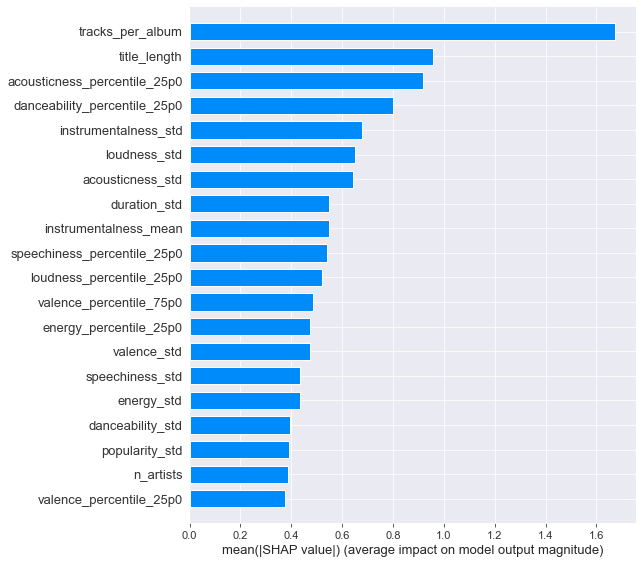

None

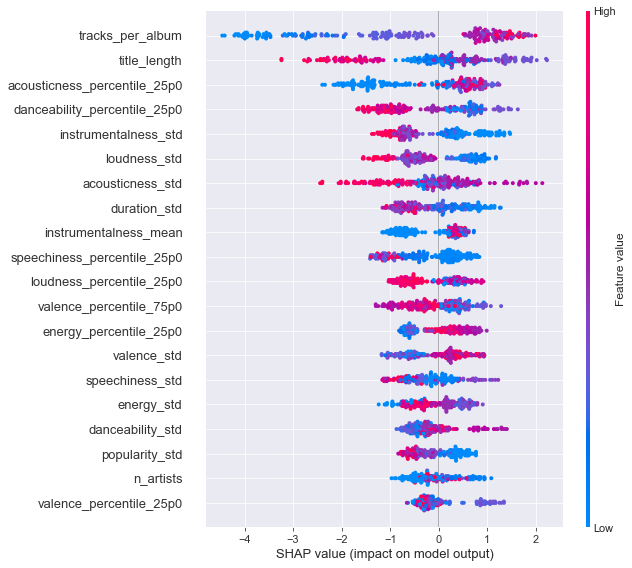

None

In [6]:
dict_models = {}
dict_explainers = {}
dict_shap = {}
dict_train = {}
for genre in GENRES:
    try:
        from pycaret.classification import *
        logging.info(f'{genre}-----------------------------------------------------------------------------------------')
        fig, ax = plt.subplots()
        plt.title(f"{genre}", size=40)
        plt.show()

        genre_frame = data.loc[lambda f: f["genre_1"].isin([genre])]
        labelled_frame = classify_success(genre_frame, users_threshold, success_threshold)
        train_frame, holdout_frame = create_holdout(labelled_frame, holdout_fraction=holdout_fraction)

        print(f"Train size: {len(train_frame)}")
        print(f"Train size: {len(holdout_frame)}")

        experiment = setup(
            data=train_frame,
            numeric_features=MODEL_NUMERICAL_FEATURES,
            categorical_features=MODEL_CATEGORICAL_FEATURES,
            target="success_streaming_ratio_users",
            ignore_features=["playlist_uri"],
            test_data=holdout_frame,
            session_id=123,
            ignore_low_variance=True,
            remove_outliers=True,
            fix_imbalance=True,
            remove_multicollinearity=True,
            log_experiment=True,
            log_data=True,
            fold=10,
            n_jobs=-1,
            combine_rare_levels=True,
            experiment_name=genre,
            silent=True,
        )
        model = create_model(
            'xgboost',
            n_estimators=1000,
            learning_rate =0.2,
            max_depth=8,
            min_child_weight=1,
            gamma=0,
            subsample=0.8,
            colsample_bytree=0.8,
            nthread=4,
            scale_pos_weight=1
        )
        exp = pull()
        display(exp)

        # Track & Save the model
        dict_models[genre] = model
        model_name = f'{genre}_xgboost_2020-04-13.pickle.dat'
        pickle.dump(model, open(model_name, "wb"))
        logging.info("Model Save Success!")

        X_train = get_config(variable="X_train")
        y_train = get_config(variable="y_train")
        
        X_test = get_config(variable="X_test")
        y_test = get_config(variable="y_test")
        
        view = pd.merge(y_train, X_train, left_index=True, right_index=True).reset_index(drop=True)
        dict_train[genre] = view
        
        X_train.to_parquet(f"../data/pycaret/X_train_{genre}")
        pd.DataFrame(y_train).to_parquet(f"../data/pycaret/y_train_{genre}")
        X_test.to_parquet(f"../data/pycaret/X_test_{genre}")
        pd.DataFrame(y_test).to_parquet(f"../data/pycaret/y_test_{genre}")

        # PLOTS
        explainer = shap.TreeExplainer(model)
        dict_explainers[genre]=explainer

        shap_values = explainer.shap_values(X_train.to_numpy())
        dict_shap[genre]=shap_values

        display(genre)
        display(shap.summary_plot(shap_values, X_train, plot_type="bar"))
        display(shap.summary_plot(shap_values, X_train))
    except:
        failed.append(genre)
        pass

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7727,0.7183,0.2548,0.5281,0.3438,0.2261,0.2480
1,0.7649,0.7103,0.2448,0.4938,0.3273,0.2040,0.2225
2,0.7709,0.7177,0.2494,0.5202,0.3372,0.2189,0.2405
3,0.7674,0.7187,0.2519,0.5039,0.3359,0.2135,0.2324
4,0.7586,0.7110,0.2349,0.4662,0.3124,0.1848,0.2008
5,0.7625,0.7014,0.2287,0.4820,0.3102,0.1882,0.2074
6,0.7642,0.7148,0.2550,0.4903,0.3355,0.2092,0.2257
7,0.7663,0.7101,0.2364,0.4992,0.3209,0.2009,0.2214
8,0.7701,0.7230,0.2450,0.5163,0.3323,0.2142,0.2360
9,0.7625,0.7118,0.2403,0.4829,0.3209,0.1962,0.2137


INFO:logs:create_model_container: 1
INFO:logs:master_model_container: 1
INFO:logs:display_container: 2
INFO:logs:XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.2, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=-1, nthread=4, num_parallel_tree=1,
              objective='binary:logistic', random_state=123, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=0.8,
              tree_method='auto', use_label_encoder=True, validate_parameters=1,
              verbosity=0)
INFO:logs:create_model() succesfully completed......................................


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7727,0.7183,0.2548,0.5281,0.3438,0.2261,0.2480
1,0.7649,0.7103,0.2448,0.4938,0.3273,0.2040,0.2225
2,0.7709,0.7177,0.2494,0.5202,0.3372,0.2189,0.2405
3,0.7674,0.7187,0.2519,0.5039,0.3359,0.2135,0.2324
4,0.7586,0.7110,0.2349,0.4662,0.3124,0.1848,0.2008
5,0.7625,0.7014,0.2287,0.4820,0.3102,0.1882,0.2074
6,0.7642,0.7148,0.2550,0.4903,0.3355,0.2092,0.2257
7,0.7663,0.7101,0.2364,0.4992,0.3209,0.2009,0.2214
8,0.7701,0.7230,0.2450,0.5163,0.3323,0.2142,0.2360
9,0.7625,0.7118,0.2403,0.4829,0.3209,0.1962,0.2137


INFO:root:Model Save Success!
INFO:logs:Initializing get_config()
INFO:logs:get_config(variable=X_train)
INFO:logs:Global variable: X_train returned as        n_tracks  n_albums  tracks_per_album  artists_per_album  title_length  \
0         144.0     114.0          1.263158           0.798246           2.0   
1         210.0     122.0          1.721311           0.778689           3.0   
2          57.0      53.0          1.075472           0.886792           2.0   
4         147.0      13.0         11.307693           0.153846           3.0   
5         221.0     172.0          1.284884           1.034884           2.0   
...         ...       ...               ...                ...           ...   
58150     361.0     180.0          2.005556           1.422222           1.0   
58151      24.0       1.0         24.000000           8.000000           2.0   
58152      59.0       1.0         59.000000           1.000000           2.0   
58153      16.0       1.0         16.000000     

INFO:logs:get_config() succesfully completed......................................
INFO:logs:Initializing get_config()
INFO:logs:get_config(variable=y_test)
INFO:logs:Global variable: y_test returned as 0       1
1       1
2       1
3       1
4       1
       ..
3057    0
3058    0
3059    0
3060    0
3061    0
Name: success_streaming_ratio_users, Length: 3062, dtype: int64
INFO:logs:get_config() succesfully completed......................................


'ALL'

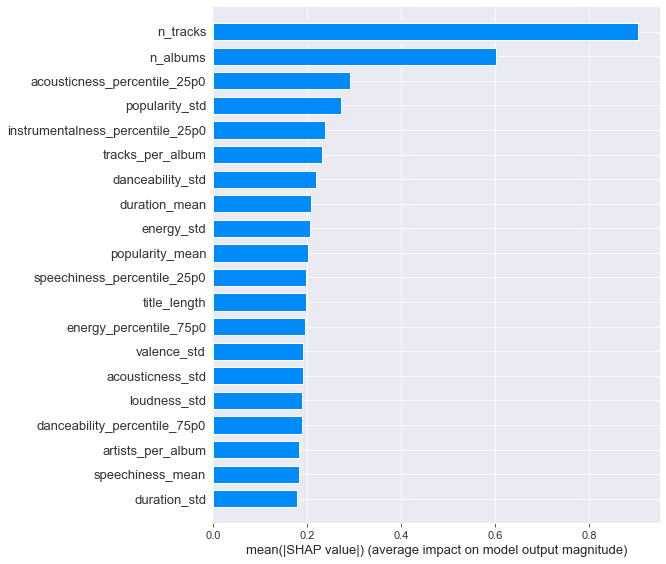

None

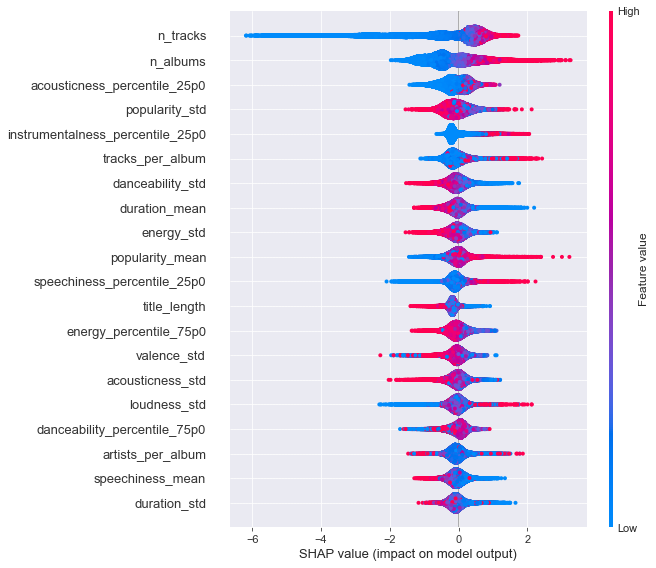

None

In [7]:
genre = "ALL"

genre_frame = data
labelled_frame = classify_success(genre_frame, users_threshold, success_threshold)
train_frame, holdout_frame = create_holdout(labelled_frame, holdout_fraction=holdout_fraction)

print(f"Train size: {len(train_frame)}")
print(f"Train size: {len(holdout_frame)}")

experiment = setup(
    data=train_frame,
    numeric_features=MODEL_NUMERICAL_FEATURES,
    categorical_features=MODEL_CATEGORICAL_FEATURES,
    target="success_streaming_ratio_users",
    ignore_features=["playlist_uri"],
    test_data=holdout_frame,
    session_id=123,
    ignore_low_variance=True,
    remove_outliers=True,
    fix_imbalance=True,
    remove_multicollinearity=True,
    log_experiment=True,
    log_data=True,
    fold=10,
    n_jobs=-1,
    combine_rare_levels=True,
    experiment_name=genre,
    silent=True,
)
model = create_model(
    'xgboost',
    n_estimators=1000,
    learning_rate =0.2,
    max_depth=8,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    nthread=4,
    scale_pos_weight=1
)
exp = pull()
display(exp)

# Track & Save the model
dict_models[genre] = model
model_name = f'{genre}_xgboost_2020-04-13.pickle.dat'
pickle.dump(model, open(model_name, "wb"))
logging.info("Model Save Success!")

X_train = get_config(variable="X_train")
y_train = get_config(variable="y_train")

X_test = get_config(variable="X_test")
y_test = get_config(variable="y_test")

view = pd.merge(y_train, X_train, left_index=True, right_index=True).reset_index(drop=True)
dict_train[genre] = view

X_train.to_parquet(f"../data/pycaret/X_train_{genre}")
pd.DataFrame(y_train).to_parquet(f"../data/pycaret/y_train_{genre}")
X_test.to_parquet(f"../data/pycaret/X_test_{genre}")
pd.DataFrame(y_test).to_parquet(f"../data/pycaret/y_test_{genre}")

# PLOTS
explainer = shap.TreeExplainer(model)
dict_explainers[genre]=explainer

shap_values = explainer.shap_values(X_train.to_numpy())
dict_shap[genre]=shap_values

display(genre)
display(shap.summary_plot(shap_values, X_train, plot_type="bar"))
display(shap.summary_plot(shap_values, X_train))

In [8]:
print("Alex you are here!")

Alex you are here!


In [30]:
X_train.to_parquet(f"../data/pycaret/X_train_{genre}")
pd.DataFrame(y_train).to_parquet(f"../data/pycaret/y_train_{genre}")
X_test.to_parquet(f"../data/pycaret/X_test_{genre}")
pd.DataFrame(y_test).to_parquet(f"../data/pycaret/y_test_{genre}")

In [29]:
pd.DataFrame(y_test)

,success_streaming_ratio_users
0,1
1,1
2,1
3,0
4,0
5,0


In [18]:
results = predict_model(model)

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.2, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=-1, nthread=4, num_parallel_tree=1,
              objective='binary:logistic', random_state=123, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=0.8,
              tree_method='auto', use_label_encoder=True, validate_parameters=1,
              verbosity=0), probability_threshold=None, encoded_labels=False, raw_score=False, round=4, verbose=True, ml_usecase=MLUsecase.CLASSIFICATION, display=None)
INFO:logs:Checking exceptions
INFO:logs:Preloading libraries
INFO:logs:Preparing display monitor


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extreme Gradient Boosting,0.6667,0.6667,0.3333,1.0000,0.5000,0.3333,0.4472


In [21]:
model.predict(X_test)

NameError: name 'X_test' is not defined

In [25]:
X_test = get_config(variable="X_test")
y_test = get_config(variable="y_test")

INFO:logs:Initializing get_config()
INFO:logs:get_config(variable=X_test)
INFO:logs:Global variable: X_test returned as    n_artists  tracks_per_album  title_length  acousticness_percentile_25p0  \
0        1.0              15.0           3.0                       0.33900   
1       10.0              12.0           5.0                       0.57925   
2        1.0              24.0           4.0                       0.71250   
3        1.0              10.5           1.0                       0.10900   
4        1.0               1.0           3.0                       0.74900   
5        1.0               7.0           3.0                       0.14200   

   danceability_percentile_25p0  duration_percentile_25p0  \
0                        0.6120                  166067.0   
1                        0.4790                  187033.5   
2                        0.7940                   87481.5   
3                        0.3640                  212507.0   
4                        0.4

In [24]:
model.predict(X_test)

array([1, 0, 0, 0, 0, 0])

In [10]:
dict_models.ke

dict_keys(['Alternative', 'Blues', "Children's", 'Classical', 'Country & Folk', 'Dance & House', 'Easy Listening', 'Electronica'])

In [15]:
loaded_model = pickle.load(open("Pop_xgboost_2020-04-13.pickle.dat", "rb"))


In [16]:
loaded_model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.2, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=-1, nthread=4, num_parallel_tree=1,
              objective='binary:logistic', random_state=123, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=0.8,
              tree_method='auto', use_label_encoder=True, validate_parameters=1,
              verbosity=0)

In [ ]:
genre_frame = base_frame.loc[lambda f: f["genre_1"].isin(genre)]

        labelled_frame = load_success_data(
            genre_frame, users_threshold, success_threshold
        )
        train_frame, holdout_frame = create_holdout(
            labelled_frame, holdout_fraction=holdout_fraction
        )

        # PyCaret setup to train models
        experiment = setup(
            data=train_frame,
            numeric_features=MODEL_NUMERICAL_FEATURES,
            categorical_features=MODEL_CATEGORICAL_FEATURES,
            target="success_streaming_ratio_users",
            ignore_features=["playlist_uri"],
            test_data=holdout_frame,
            session_id=123,
            ignore_low_variance=True,
            remove_outliers=True,
            fix_imbalance=True,
            remove_multicollinearity=True,
            log_experiment=True,
            log_data=True,
            fold=2,
            n_jobs=-1,
            combine_rare_levels=True,
            experiment_name=experiment_name,
            silent=True,
        )

        list_models = compare_models(
            n_select=5, round=3, cross_validation=False, include=include_models
        )
        exp = pull()
        st.dataframe(exp)